# Closed Loop Mass Spectrometry - Simple Example

The following notebook provides a simplified example related to closed loop mass spectrometry experiements. In these experiments we observe metabolites across multiple sample. The locations of the metabolites remain similar but are subject to a systematic change in the time that they occur. This example shows how it is possible to estimate this time drift and match the metabolites across samples. 

## 1. Load some packages

In [1]:
import numpy as np
import copy

In [2]:
import pylab as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('../..')

In [4]:
from CLGP import *

In [5]:
%load_ext autoreload
%autoreload 2

## 2. Create Data

- In an initial experiment we have measured a set of objects (metabolites), each of which is characterised by time. For some of these objects we also have some information to uniquely identify them.
- In a second experiment we then measure another set of objects, some of which will be the same as objects in the first experiment and some will not
- For those objects that match between the experiments, there will be a time drift with respect to the time they were observed in the first experiment
- Our goal is to match the objects which are the same via inferring the time drift between experiments
- We can learn the drift using points that we can match (based upon the additional information described above). But there is a cost associated with these additional measurements and we can make only a limited number of them
- When we make such a measurement it will tell us that either:
    - the point we measure is the same as one of the ones in set 1 for which the additional information is available, or...
    - it is not the same as any for which additional information is available
    
Note: in reality, the problem is more constrained as we have to make the additional measurements in time order...

### 2.1. Create Initial Dataset

In total we have `N` objects across our two samples. In total each sample contains `n_data` of the `N` objects, meaning that there is overlap between the two samples

In [6]:
N = 30 # total number of objects which could be in either dataset
n_data = 25 # total number of objects in a dataset
true_vals, data_1_idx, data_2_idx = create_dataset(N, n_data)

Size of Overlap between datasets = 20


In [7]:
true_vals

array([0.055114  , 0.05761956, 0.05929999, 0.09623112, 0.12850265,
       0.13818775, 0.15877374, 0.16518027, 0.17545502, 0.17576426,
       0.24662272, 0.38900386, 0.40343658, 0.40704314, 0.4579976 ,
       0.46957375, 0.47409717, 0.48474923, 0.54837514, 0.59064771,
       0.6395755 , 0.69630598, 0.72838672, 0.80149459, 0.81793993,
       0.83858232, 0.85166365, 0.90010756, 0.90585853, 0.9480183 ])

During the first experiment, some of the objects in the first sample had additional information collected about them. This information uniquely identifies the object and allows it to be matched to the same object in the second sample, even if the times are significantly different. We cannot confirm the identity of any object without this additional information, and therefore cannot match it to the second sample.

In [8]:
frag_prob_1 = 0.7
frag_1 = add_frag_events(n_data, frag_prob_1)

We can plot the time that the objects are observed in the first sample (x-axis) against their index (y-axis). Here we see that some objects have additional information and some do not. Note, we do not use the index (y-axis) to match the objects, it just helps with plotting.

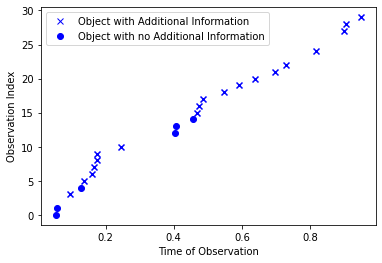

In [9]:
plot_frag_dataset(true_vals, data_1_idx, frag_1)

### 2.2. Create Drift Function

Next we sample the time drift for the objects in the second dataset using a Gaussian Process (GP)

In [10]:
alpha = 0.01
gam = 1.
K, true_offset_function = create_drift(true_vals, alpha, gam)

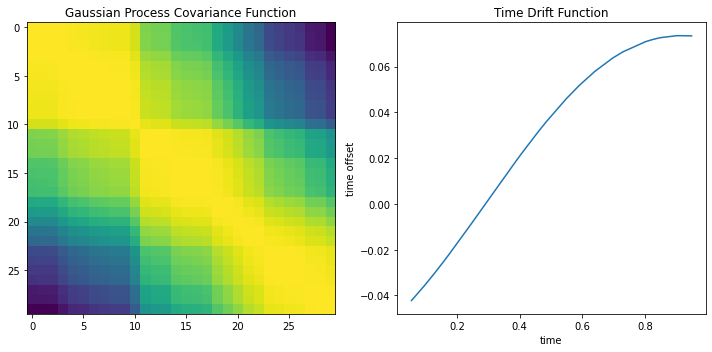

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # label this
ax = axes[0]
ax.set_title('Gaussian Process Covariance Function')
plot = ax.imshow(K,aspect='auto')
plt.plot(true_vals,true_offset_function)
plt.title('Time Drift Function')
plt.xlabel('time')
plt.ylabel('time offset')
fig.tight_layout()
plt.show()

### 2.3. Create Observed Datasets

Using the generated time drift from the GP, we can now generate the observed times for the second sample. Dataset 1 (black dots) takes the original times we generated, with the dataset 2 (green dots) taking those times plsu the time drift and some random noise.

In [12]:
noise_ss = 0.00000
observed_1, observed_2, main_K = create_observed_datasets(true_vals, data_1_idx, data_2_idx, true_offset_function, noise_ss, alpha, gam)

We can now plot the data, where true matches are shown as horizontal lines (any non-horizontal line would be an incorrect match). Note that some objects do not have matches as they only appear in one of the two datasets.

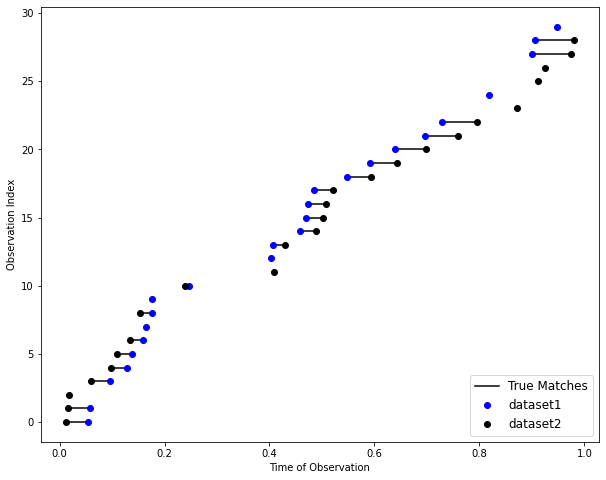

In [13]:
plot_datasets(observed_1, observed_2, data_1_idx, data_2_idx, true_matching=True, figsize=(10,8))

# 3. Example Process

The following is a walk through of the update process

## 4. Full Example

__Plots__
- left plot - The current drift values for each matched against the time of the object from dataset2. The drift and estimated drift are also show
- right plot - the observation times of the objects for each datasets against their index. Currently matched objects are show along with whether that match is confirmed, unconfirmed or incorrect.

__Process__

At each iteration, where each row of plots is a new iteration, the following happens
- query an unqueried point at random
- see if it matches anything in the first sample
- if so add it to the confirmed list, if not confirmed list remains the same
- update the time drift prediction
- update matching based on confirmed list and closest matches after correction for time drift

Initial matches based on no time drift and picking the closest matches.
For the figure below, there is a total of 12 matches, of which there are 1 correct and 11 incorrect.


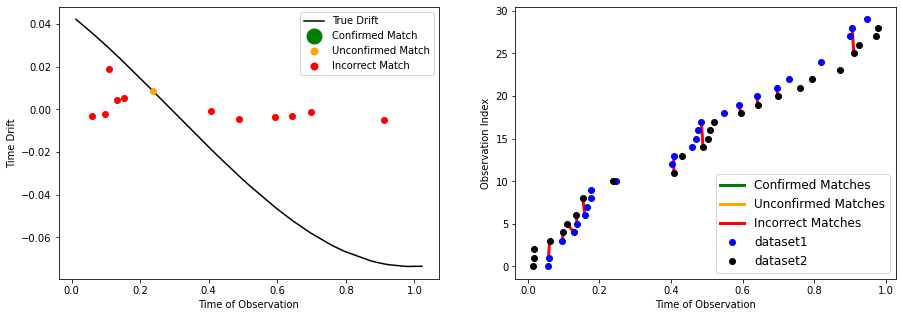

The next query resulted in a new confirmed match. The GP has been refitted and the matching updated.
For the figure below, there are now a total of 14 matches, of which there are 1 confirmed, 5 unconfirmed and 8 incorrect.


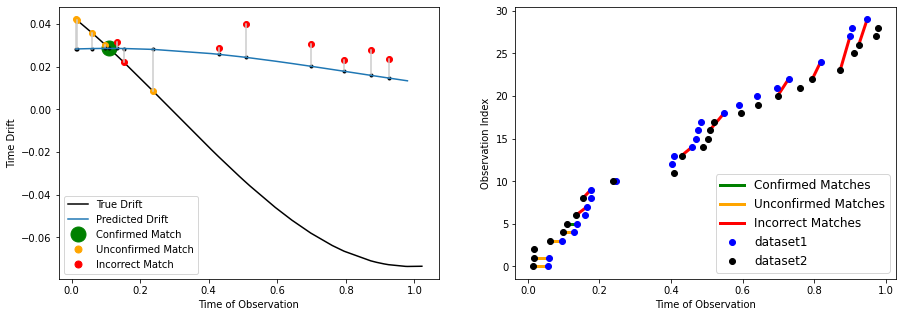

The next query resulted in a new confirmed match. The GP has been refitted and the matching updated.
For the figure below, there are now a total of 20 matches, of which there are 2 confirmed, 12 unconfirmed and 6 incorrect.


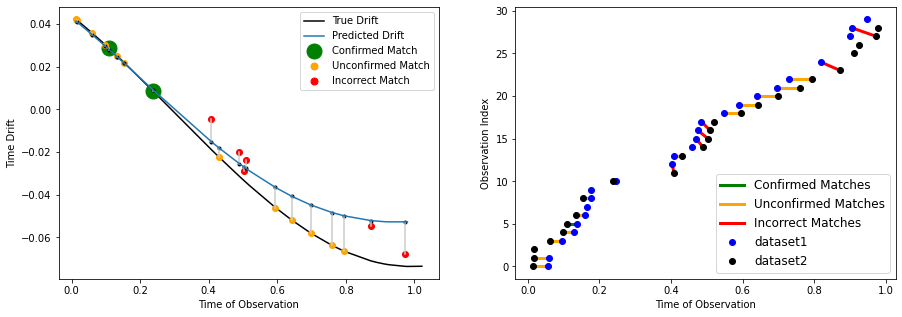

The next query resulted in a new confirmed match. The GP has been refitted and the matching updated.
For the figure below, there are now a total of 22 matches, of which there are 3 confirmed, 17 unconfirmed and 2 incorrect.


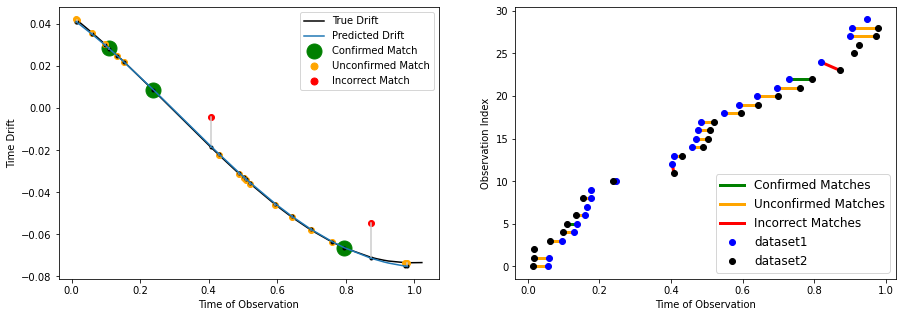

The next query did not match anything previously observed.
For the figure below, there are now a total of 22 matches, of which there are 3 confirmed, 17 unconfirmed and 2 incorrect.


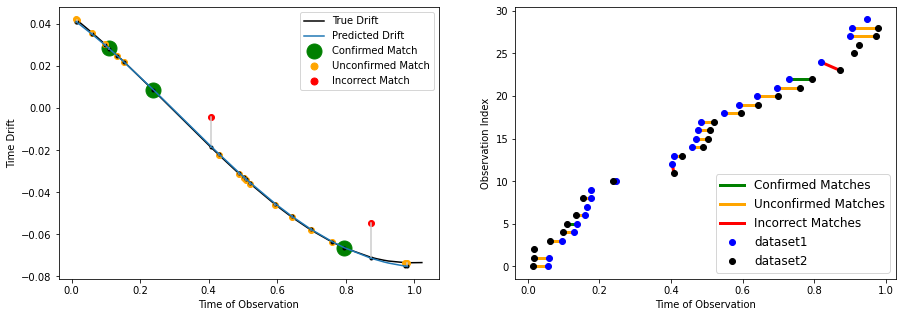

The next query did not match anything previously observed.
For the figure below, there are now a total of 22 matches, of which there are 3 confirmed, 17 unconfirmed and 2 incorrect.


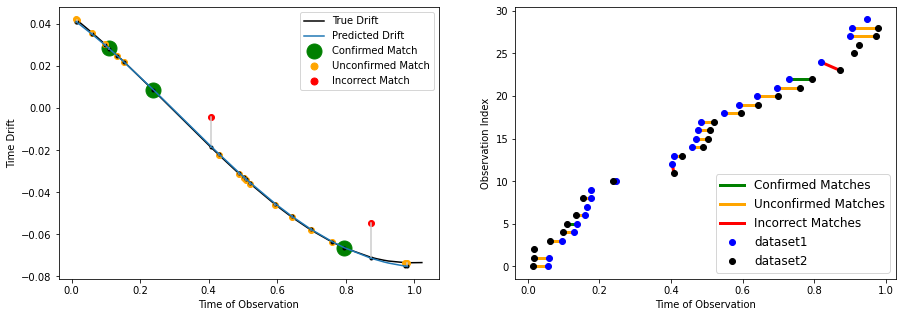

In [14]:
n_its = 5
max_rt = 0.02
match_method = 'max_drift'  # options: 'max_drift', 'max_drift_weighted'. If no option is given, then just picks at random
SimpleExperiment(n_its,observed_1, observed_2, data_1_idx, data_2_idx, frag_1, main_K, match_method, max_rt,true_vals,true_offset_function).run()